<a href="https://colab.research.google.com/github/podo47/DL_HW2_LeNet-Computational_Graph/blob/main/DL_HW2_Computational_Graph.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Computational Graph

## Mount to drive

In [1]:
from google.colab import drive
drive.mount('/content/drive') 

Mounted at /content/drive


## Import libraries

In [2]:
import os
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
from PIL import Image
import cv2

In [3]:
import warnings
warnings.filterwarnings('ignore')

## Part 1 : Data preprocessing

### Import data

In [4]:
train = pd.read_csv('/content/drive/MyDrive/images/train.txt', sep=" ",header=None)
train_dir = np.array(train[0])
train_y = np.array(train[1])

valid = pd.read_csv('/content/drive/MyDrive/images/val.txt', sep=" ",header=None)
valid_dir = np.array(valid[0])
valid_y = np.array(valid[1])

test = pd.read_csv('/content/drive/MyDrive/images/test.txt', sep=" ",header=None)
test_dir = np.array(test[0])
test_y = np.array(test[1])

### Color Histogram (COG) : Can skip

In [ ]:
def color_histogram(image, bins=8):
    # Convert the grayscale image to a 3-channel rgb image
    image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
    # Convert the rgb image to HSV 
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    # Calculate the histogram
    hist = np.zeros((bins ** 3,))
    for i in range(hsv.shape[0]):
        for j in range(hsv.shape[1]):
            h, s, v = hsv[i, j]
            bin_idx = int(h / (180 / bins)) * bins * bins + int(s / (256 / bins)) * bins + int(v / (256 / bins))
            hist[bin_idx] += 1

    # Normalize the histogram
    hist /= np.sum(hist)

    return hist

In [ ]:
def coh_dataset(X_dataset):
  X_feature = []
  for image in X_dataset:
      feature = color_histogram(image)
      X_feature.append(feature)

  # Convert the feature list to a numpy array
  X_feature = np.array(X_feature)
  return X_feature

Done before : read image into array and save as "dataset.npz"

In [ ]:
with np.load("/content/drive/MyDrive/images/dataset.npz") as data:
    X_train = data["traindata"]
    X_valid = data["validdata"]
    X_test = data["testdata"]

In [ ]:
coh_train_features = coh_dataset(X_train)
coh_valid_features = coh_dataset(X_valid)
coh_test_features = coh_dataset(X_test)

Save (Can skip)

In [ ]:
# Save to a file
np.savez("/content/drive/MyDrive/images/cog_data.npz", cog_train_data=coh_train_features, cog_valid_data=coh_valid_features,cog_test_data=coh_test_features)

### Load feature vector and target variable (COG)

In [5]:
with np.load("/content/drive/MyDrive/images/cog_data.npz") as data:
    cog_train = data["cog_train_data"]
    cog_valid = data["cog_valid_data"]
    cog_test = data["cog_test_data"]

In [6]:
print(cog_train.shape)
print(cog_valid.shape)
print(cog_test.shape)

(63325, 512)
(450, 512)
(450, 512)


### Load feature vector and target variable (HOG)

Done before : use Histogram of Gradient (HOG) to do Feature Extraction and save as "hog_data.npz"

In [7]:
with np.load("/content/drive/MyDrive/images/hog_data.npz") as data:
    hog_train = data["hog_train_data"]
    hog_valid = data["hog_valid_data"]
    hog_test = data["hog_test_data"]

In [8]:
print(hog_train.shape)
print(hog_valid.shape)
print(hog_test.shape)

(63325, 588)
(450, 588)
(450, 588)


## Part 2 : Two-layer perceptron

In [46]:
class TLP:
  def __init__(self, n_input, n_hidden, n_output, lr=0.001):
    self.n_input = n_input
    self.n_hidden = n_hidden
    self.n_output = n_output
    self.lr = lr

    self.W1 = np.random.normal(0, 0.1, (n_input, n_hidden))
    self.b1 = np.zeros(n_hidden)
    self.W2 = np.random.normal(0, 0.1, (n_hidden, n_output))
    self.b2 = np.zeros(n_output)

  def relu(self, Z):
    A = np.maximum(Z, 0)
    return A

  def sigmoid(self, Z):
    A = A = 1/(1 + np.exp(-Z))
    return A

  def softmax(self, A):
    soft_a = np.exp(A - np.max(A, axis=1, keepdims=True))
    return soft_a / np.sum(soft_a, axis=1, keepdims=True)

  def forward(self, X):
    Z1 = np.dot(X, self.W1) + self.b1
    A1 = self.relu(Z1)
    Z2 = np.dot(A1, self.W2) + self.b2
    A2 = self.relu(Z2)
    probs = self.softmax(A2)
    return probs, A1

  def backward(self, X, y, probs, A1):
    delta_out = probs
    delta_out[range(X.shape[0]), y] -= 1
    delta_hid = np.dot(delta_out, self.W2.T) * (A1 > 0)
    dW2 = np.dot(A1.T, delta_out)
    db2 = np.sum(delta_out, axis=0)
    dW1 = np.dot(X.T, delta_hid)
    db1 = np.sum(delta_hid, axis=0)
    return dW1, db1, dW2, db2

  def train(self,extract_type, X_train, y_train, X_val, y_val, n_epochs, batch_size):
    n_train = X_train.shape[0]
    n_batches = n_train // batch_size
    train_acc1_rec = []
    train_acc5_rec = []
    val_acc1_rec = []
    val_acc5_rec = []

    for i in range(n_epochs):
        # Shuffle training data
        idx = np.random.permutation(n_train)
        X_train = X_train[idx]
        y_train = y_train[idx]

        for j in range(n_batches):
            start = j * batch_size
            end = start + batch_size
            X_batch = X_train[start:end]
            y_batch = y_train[start:end]

            # Forward pass
            probs, A1 = self.forward(X_batch)

            # Backward pass
            dW1, db1, dW2, db2 = self.backward(X_batch, y_batch, probs, A1)

            # Update weights
            self.W1 -= self.lr * dW1
            self.b1 -= self.lr * db1
            self.W2 -= self.lr * dW2
            self.b2 -= self.lr * db2

            
        # Record n_epoch's training accuracy
        y_train_hat, y_train_prob = self.predict(X_train)
        acc_train_top1, acc_train_top5 = self.accuracy(y_train_prob, y_train_hat, y_train, k=5)
        train_acc1_rec.append(acc_train_top1)
        train_acc5_rec.append(acc_train_top5)
            
        # Record n_epoch's validation accuracy
        y_val_hat, y_prob = self.predict(X_val)
        acc_val_top1, acc_val_top5 = self.accuracy(y_prob, y_val_hat, y_val, k=5)
        val_acc1_rec.append(acc_val_top1)
        val_acc5_rec.append(acc_val_top5)

          
        # Print validation accuracy every 10 epochs
        if (i + 1) % 1 == 0 and X_val is not None and y_val is not None:
            print("Epoch {0}: train top-1 acc = {1:.4f}, train top-5 acc = {2:.4f} / val top-1 acc = {3:.4f}, val top-5 acc = {4:.4f}".format(i + 1, acc_train_top1, acc_train_top5, acc_val_top1, acc_val_top5))

    # Draw diagram: Accuracy
    plt.figure(figsize=(20,10))
    plt.xlabel("Epochs", fontsize=20)
    plt.ylabel("Accuracy ", fontsize=20)

    plt.plot(train_acc1_rec, label="Train Top-1")
    plt.plot(train_acc5_rec, label="Train Top-5")
    plt.plot(val_acc1_rec, label="Val Top-1")
    plt.plot(val_acc5_rec, label="Val Top-5")
    plt.title('Train / Validation Accuracy (' + extract_type + ')', fontsize=30)
    plt.legend(loc=2, fontsize=20)
    plt.grid(True)
    plt.savefig("/content/drive/MyDrive/DL/HW2/TLP_" + extract_type + '_accuracy.png')
    plt.show()

  def predict(self, X):
    y_prob,A1 = self.forward(X)
    y_hat = np.argmax(y_prob, axis=1)
    return y_hat,y_prob

  def accuracy(self, y_prob, y_hat, y, k=5):
    predictions = np.argsort(y_prob, axis=1)[:, -k:]
    correct_topk = np.sum(np.any(predictions == y.reshape(-1, 1), axis=1))
    correct_top1 = np.sum(y_hat == y)
    return correct_top1 / y.shape[0], correct_topk / y.shape[0]

  def test(self, X_test, y_test, k=5):
    # Forward pass
    y_pred, y_prob = self.predict(X_test)
          
    # Calculate accuracy
    top1_acc, topk_acc = self.accuracy(y_prob, y_pred, y_test, k=k)
    print("Test top-1 acc = {0:.4f} /n Test top-5 acc = {1:.4f}".format(top1_acc, topk_acc))
    return top1_acc, topk_acc, y_pred, y_prob


### Predicted result

In [50]:
def answer(test_y, test_y_pred, test_y_prob, data_name, output_name):
  test_y_prob = test_y_prob[range(len(test_y)),np.argmax(test_y_prob,axis=1)]
  df = np.column_stack((test_y, test_y_pred, test_y_prob))
  test_result = pd.DataFrame(df, index=data_name, columns=['Answer','Prediction','Prediction prob'])
  test_result.to_csv('/content/drive/MyDrive/DL/HW2/' + output_name + '_test_result.csv')
  return test_result

### A. HOG

#### Train

In [10]:
# Initialize TwoLayerPerceptron model
model_hog = TLP(n_input=hog_train.shape[1], n_hidden=512, n_output=50, lr=0.001)

Epoch 1: train top-1 acc = 0.1110, train top-5 acc = 0.3450 / val top-1 acc = 0.0200, val top-5 acc = 0.1000
Epoch 2: train top-1 acc = 0.1451, train top-5 acc = 0.4188 / val top-1 acc = 0.0200, val top-5 acc = 0.1022
Epoch 3: train top-1 acc = 0.1867, train top-5 acc = 0.4777 / val top-1 acc = 0.0222, val top-5 acc = 0.1000
Epoch 4: train top-1 acc = 0.2168, train top-5 acc = 0.5196 / val top-1 acc = 0.0200, val top-5 acc = 0.1089
Epoch 5: train top-1 acc = 0.2385, train top-5 acc = 0.5514 / val top-1 acc = 0.0200, val top-5 acc = 0.1000
Epoch 6: train top-1 acc = 0.2701, train top-5 acc = 0.5898 / val top-1 acc = 0.0200, val top-5 acc = 0.1044
Epoch 7: train top-1 acc = 0.3020, train top-5 acc = 0.6231 / val top-1 acc = 0.0200, val top-5 acc = 0.1000
Epoch 8: train top-1 acc = 0.3203, train top-5 acc = 0.6444 / val top-1 acc = 0.0222, val top-5 acc = 0.0978
Epoch 9: train top-1 acc = 0.3449, train top-5 acc = 0.6690 / val top-1 acc = 0.0200, val top-5 acc = 0.1000
Epoch 10: train top

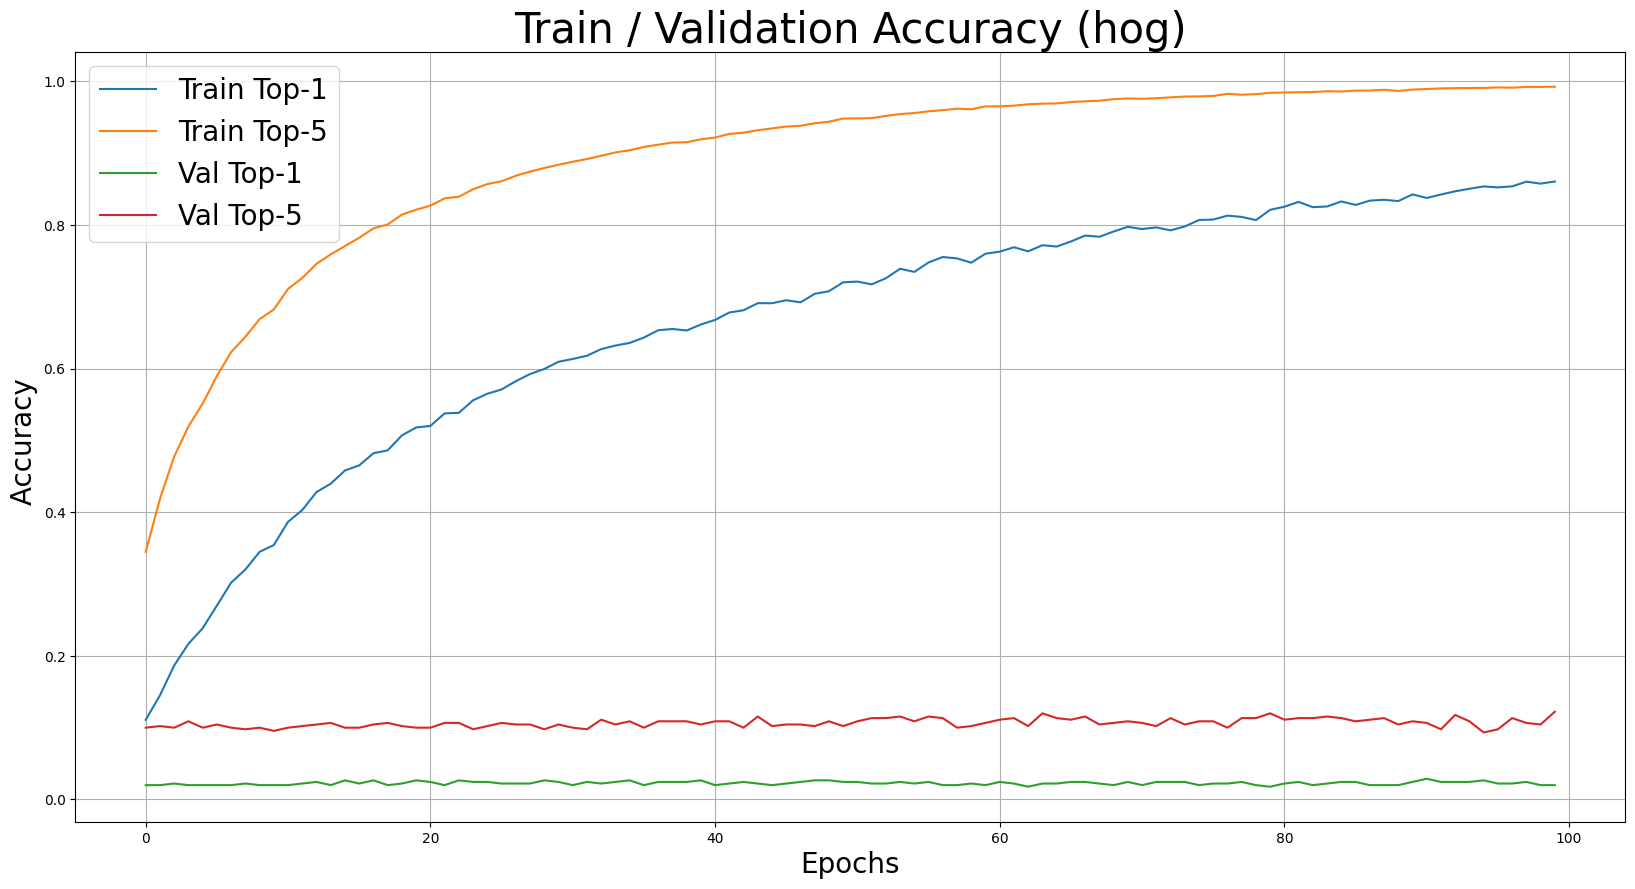

In [11]:
# Train model
extract_type = 'hog'
model_hog.train(extract_type, hog_train, train_y, hog_valid, valid_y, n_epochs=100, batch_size=64)

#### Test

In [48]:
# Test model
hog_test_acc1, hog_test_acc5, hog_test_y_pred, hog_test_y_prob = model_hog.test(hog_test,test_y)

Test top-1 acc = 0.0200 /n Test top-5 acc = 0.0978


In [51]:
# Predict result
output_name = 'hog'
hog_answer = answer(test_y, hog_test_y_pred, hog_test_y_prob, test_dir, output_name)
hog_answer

,Answer,Prediction,Prediction prob
images/n02111277/n02111277_9420.JPEG,0.0,37.0,0.998101
images/n02111277/n02111277_9422.JPEG,0.0,37.0,0.901552
images/n02111277/n02111277_9484.JPEG,0.0,37.0,0.974189
images/n02111277/n02111277_951.JPEG,0.0,37.0,0.988838
images/n02111277/n02111277_9518.JPEG,0.0,37.0,0.979019
...,...,...,...
images/n02172182/n02172182_974.JPEG,49.0,37.0,0.982722
images/n02172182/n02172182_9765.JPEG,49.0,37.0,0.955220
images/n02172182/n02172182_9789.JPEG,49.0,37.0,0.995012
images/n02172182/n02172182_98.JPEG,49.0,37.0,0.946389


### B. COG

#### Train

In [66]:
# Initialize TwoLayerPerceptron model
model_cog = TLP(n_input=cog_train.shape[1], n_hidden=512, n_output=50, lr=0.001)

Epoch 1: train top-1 acc = 0.0400, train top-5 acc = 0.1654 / val top-1 acc = 0.0356, val top-5 acc = 0.1578
Epoch 2: train top-1 acc = 0.0428, train top-5 acc = 0.1717 / val top-1 acc = 0.0467, val top-5 acc = 0.1778
Epoch 3: train top-1 acc = 0.0418, train top-5 acc = 0.1747 / val top-1 acc = 0.0356, val top-5 acc = 0.1867
Epoch 4: train top-1 acc = 0.0412, train top-5 acc = 0.1754 / val top-1 acc = 0.0333, val top-5 acc = 0.1511
Epoch 5: train top-1 acc = 0.0430, train top-5 acc = 0.1748 / val top-1 acc = 0.0422, val top-5 acc = 0.1733
Epoch 6: train top-1 acc = 0.0398, train top-5 acc = 0.1747 / val top-1 acc = 0.0422, val top-5 acc = 0.1733
Epoch 7: train top-1 acc = 0.0422, train top-5 acc = 0.1766 / val top-1 acc = 0.0400, val top-5 acc = 0.1911
Epoch 8: train top-1 acc = 0.0435, train top-5 acc = 0.1795 / val top-1 acc = 0.0378, val top-5 acc = 0.1933
Epoch 9: train top-1 acc = 0.0447, train top-5 acc = 0.1818 / val top-1 acc = 0.0444, val top-5 acc = 0.1956
Epoch 10: train top

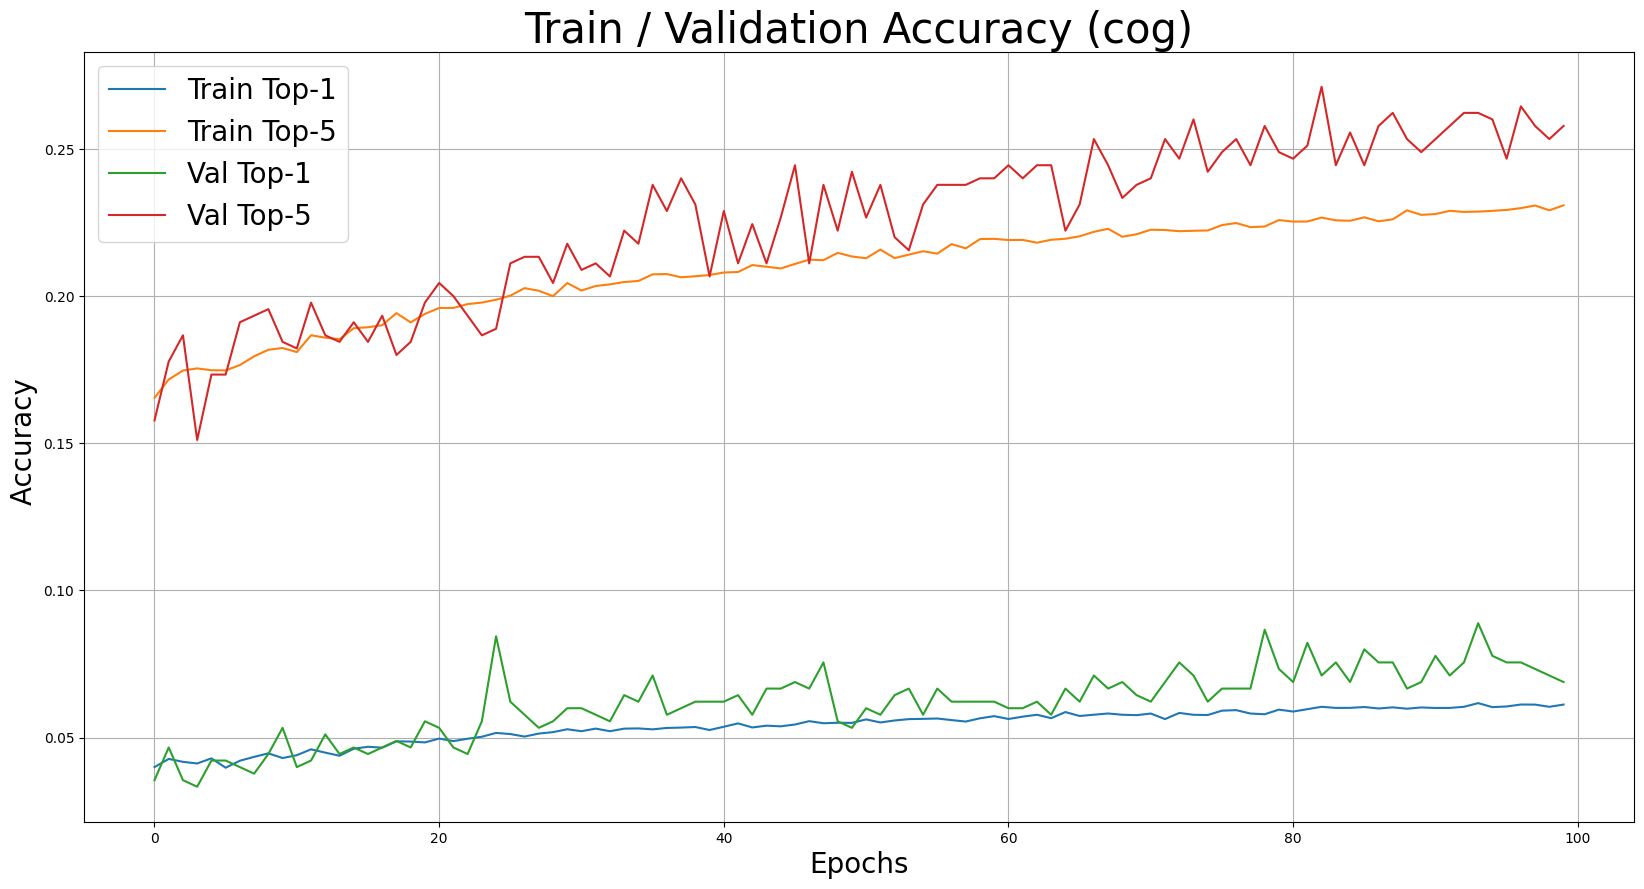

In [67]:
# Train model
extract_type = 'cog'
model_cog.train(extract_type, cog_train, train_y, cog_valid, valid_y, n_epochs=100, batch_size=64)

#### Test

In [68]:
# Test model
cog_test_acc1, cog_test_acc5, cog_test_y_pred, cog_test_y_prob = model_cog.test(cog_test,test_y)

Test top-1 acc = 0.0711 /n Test top-5 acc = 0.2333


In [69]:
# Predict result
output_name = 'cog'
cog_answer = answer(test_y, cog_test_y_pred, cog_test_y_prob, test_dir, output_name)
cog_answer

,Answer,Prediction,Prediction prob
images/n02111277/n02111277_9420.JPEG,0.0,46.0,0.068439
images/n02111277/n02111277_9422.JPEG,0.0,32.0,0.068110
images/n02111277/n02111277_9484.JPEG,0.0,25.0,0.047375
images/n02111277/n02111277_951.JPEG,0.0,0.0,0.057545
images/n02111277/n02111277_9518.JPEG,0.0,46.0,0.117946
...,...,...,...
images/n02172182/n02172182_974.JPEG,49.0,44.0,0.136112
images/n02172182/n02172182_9765.JPEG,49.0,34.0,0.043721
images/n02172182/n02172182_9789.JPEG,49.0,34.0,0.055162
images/n02172182/n02172182_98.JPEG,49.0,39.0,0.040741


## Part 3 : Performance

In [70]:
perform_df_test = pd.DataFrame([
    ['HOG', 512, 0.001, 100, 64, hog_test_acc1, hog_test_acc5],
    ['COG', 512, 0.001, 100, 64, cog_test_acc1, cog_test_acc5]],
    columns=['Feature extraction', 'n_hidden', 'lr', 'n_epochs', 'batch_size', 'top1 acc', 'top5 acc'])

In [71]:
perform_df_test

,Feature extraction,n_hidden,lr,n_epochs,batch_size,top1 acc,top5 acc
0,HOG,512,0.001,100,64,0.020000,0.097778
1,COG,512,0.001,100,64,0.071111,0.233333
